# Bypassing CAPTCHA

## Step 1 - Generating CAPTCHAs

The images are already provided in the `generated_captcha_images` folder.

## Step 2 - Extracting characters

Here we try to extract continuous pixel streaks in order to differentiate between the letters, saving successful attempts in the `extracted_letter_images` folder.

In [1]:
import os, cv2, glob, imutils

CAPTCHA_IMAGE_FOLDER = "generated_captcha_images"
LETTER_IMAGES_FOLDER = "extracted_letter_images"

# Get a list of all the captcha images we need to process
captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))
total = len(captcha_image_files)
counts = {}

# loop over the image paths
for (i, captcha_image_file) in enumerate(captcha_image_files, start=1):
    percent = round(i / total * 100, 2)
    if percent % 10 < 0.2:
        print(f"Processing images: {percent}%")

    # Since the filename contains the captcha text (i.e. "2A2X.png" has the text "2A2X"),
    # grab the base filename as the text
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]

    # Load the image and convert it to grayscale
    image = cv2.imread(captcha_image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # Threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Find the contours (continuous blobs of pixels) the image
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Now we can loop through each of the four contours and extract the letter inside of each one
    letter_image_regions = []
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter! Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Save out each letter as a single image
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_correct_text):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        # Get the folder to save the image in
        save_path = os.path.join(LETTER_IMAGES_FOLDER, letter_text)

        # if the output directory does not exist, create it
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)

        # increment the count for the current key
        counts[letter_text] = count + 1

Processing images: 50.0%
Processing images: 100.0%


## Step 3 - Training a 2D convolutional neural network

Now we preprocess the data to train a neural network to recognise the letters. All matching letters are stored in a folder of the same name to ease labeling. Once the model has been trained, it is saved to disk.

In [2]:
import pickle
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
from helpers import resize_to_fit

MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in imutils.paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)

# Scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what its predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

# Build the neural network!
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))

# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the neural network
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10, verbose=1)

# Save the trained model to disk
model.save(MODEL_FILENAME)
model.summary()

Epoch 1/10
909/909 [==============================] - 18s 19ms/step - loss: 0.2206 - accuracy: 0.9470 - val_loss: 0.0207 - val_accuracy: 0.9955
Epoch 2/10
909/909 [==============================] - 18s 19ms/step - loss: 0.0102 - accuracy: 0.9976 - val_loss: 0.0094 - val_accuracy: 0.9975
Epoch 3/10
909/909 [==============================] - 19s 21ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0086 - val_accuracy: 0.9981
Epoch 4/10
909/909 [==============================] - 20s 22ms/step - loss: 0.0079 - accuracy: 0.9979 - val_loss: 0.0138 - val_accuracy: 0.9969
Epoch 5/10
909/909 [==============================] - 19s 21ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.0503 - val_accuracy: 0.9875
Epoch 6/10
909/909 [==============================] - 21s 23ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.0107 - val_accuracy: 0.9986
Epoch 7/10
909/909 [==============================] - 19s 21ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0081 - val_accuracy:

## Step 4 - Testing the model

1/1 [==============================] - 0s 19ms/step
CAPTCHA text is: 4C92


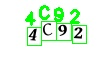

1/1 [==============================] - 0s 18ms/step
CAPTCHA text is: F6Z3


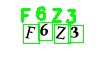

1/1 [==============================] - 0s 22ms/step
CAPTCHA text is: D4RA


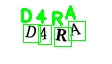

1/1 [==============================] - 0s 21ms/step
CAPTCHA text is: 4DYD


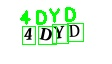

1/1 [==============================] - 0s 20ms/step
CAPTCHA text is: 2SRU


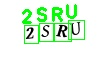

1/1 [==============================] - 0s 20ms/step
CAPTCHA text is: 9A3U


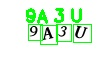

1/1 [==============================] - 0s 21ms/step
CAPTCHA text is: J3Q3


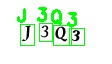

1/1 [==============================] - 0s 20ms/step
CAPTCHA text is: 7QHN


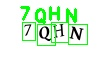

1/1 [==============================] - 0s 22ms/step
CAPTCHA text is: 9D8A


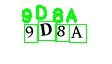

1/1 [==============================] - 0s 20ms/step
CAPTCHA text is: 4JR6


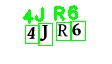

In [3]:
from keras.models import load_model

# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model(MODEL_FILENAME)

# Grab some random CAPTCHA images to test against.
# In the real world, you'd replace this section with code to grab a real
# CAPTCHA image from a live website.
captcha_image_files = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
captcha_image_files = np.random.choice(captcha_image_files, size=(10,), replace=False)

# loop over the image paths
for image_file in captcha_image_files:
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    image = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_REPLICATE)

    # Threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Find the contours (continuous blobs of pixels) the image
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Now we can loop through each of the four contours and extract the letter inside of each one
    letter_image_regions = []
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter! Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Create an output image and a list to hold our predicted letters
    output = cv2.merge([image] * 3)
    predictions = []

    # loop over the lektters
    for letter_bounding_box in letter_image_regions:
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = image[y - 2:y + h + 2, x - 2:x + w + 2]

        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = resize_to_fit(letter_image, 20, 20)

        # Turn the single image into a 4d list of images to make Keras happy
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        # Ask the neural network to make a prediction
        prediction = model.predict(letter_image)

        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

        # draw the prediction on the output image
        cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

    # Print the captcha's text
    captcha_text = "".join(predictions)
    print("CAPTCHA text is: {}".format(captcha_text))

    # Show the annotated image
    #cv2.imshow("Output", output) #ERROR error: /tmp/build/80754af9/opencv_1512491966934/work/modules/highgui/src/window.cpp:611: error: (-2) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function cvShowImage
    #WORKAROUND https://stackoverflow.com/a/11855133/8800831
    cv2.imwrite('workaround.jpg', output)
    from IPython.display import Image
    display(Image(filename='workaround.jpg'))    

As you can see, all CAPTCHAs have been broken successfully!